##Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
from shutil import copyfile
import zipfile
from time import time
import shutil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None, ignore_class=None, sparse_y_true=True, sparse_y_pred=True, axis=-1):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.ignore_class = ignore_class
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=self.axis)
        y_true = tf.cast(y_true, tf.int64)
        return super().update_state(y_true, y_pred, sample_weight)

    def result_per_class(self):
        total_cm = self.total_cm.numpy()
        with np.errstate(divide='ignore', invalid='ignore'):
            iou_per_class = total_cm / (total_cm.sum(axis=1) + total_cm.sum(axis=0) - total_cm.diagonal())
            iou_per_class[np.isnan(iou_per_class)] = 0
        return iou_per_class

In [ ]:
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/drive/MyDrive/semantic-segmentation-camvid/Data/raw.zip', 'raw.zip')
# Extract files
zipp = zipfile.ZipFile('raw.zip')

data_raw_path = '/content/data/'

zipp.extractall(data_raw_path)
zipp.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 26.849 seconds


In [ ]:
CAMVID_CLASSES = {
    'Animal': (64, 128, 64),
    'Archway': (192, 0, 128),
    'Bicyclist': (0, 128, 192),
    'Bridge': (0, 128, 64),
    'Building': (128, 0, 0),
    'Car': (64, 0, 128),
    'CartLuggagePram': (64, 0, 192),
    'Child': (192, 128, 64),
    'Column_Pole': (192, 192, 128),
    'Fence': (64, 64, 128),
    'LaneMkgsDriv': (128, 0, 192),
    'LaneMkgsNonDriv': (192, 0, 64),
    'Misc_Text': (128, 128, 64),
    'MotorcycleScooter': (192, 0, 192),
    'OtherMoving': (128, 64, 64),
    'ParkingBlock': (64, 192, 128),
    'Pedestrian': (64, 64, 0),
    'Road': (128, 64, 128),
    'RoadShoulder': (128, 128, 192),
    'Sidewalk': (0, 0, 192),
    'SignSymbol': (192, 128, 128),
    'Sky': (128, 128, 128),
    'SUVPickupTruck': (64, 128, 192),
    'TrafficCone': (0, 0, 64),
    'TrafficLight': (0, 64, 64),
    'Train': (192, 64, 128),
    'Tree': (128, 128, 0),
    'Truck_Bus': (192, 128, 192),
    'Tunnel': (64, 0, 64),
    'VegetationMisc': (192, 192, 0),
    'Void': (0, 0, 0),
    'Wall': (64, 192, 0)
}

CAMVID_CLASSES_GROUPED = {
    'Sky': ['Sky'],
    'Building': ['Archway', 'Bridge', 'Building', 'Tunnel', 'Wall'],
    'Pole': ['Column_Pole', 'TrafficCone'],  # Usando 'Pole' invece di 'Column_Pole'
    'Road': ['Road', 'LaneMkgsDriv', 'LaneMkgsNonDriv'],
    'Sidewalk': ['Sidewalk', 'ParkingBlock', 'RoadShoulder'],
    'Tree': ['Tree', 'VegetationMisc'],
    'Sign': ['TrafficLight', 'Misc_Text', 'SignSymbol'],  # Usando 'Sign' invece di 'TrafficLight'
    'Fence': ['Fence'],
    'Car': ['Car', 'OtherMoving', 'SUVPickupTruck', 'Train', 'Truck_Bus'],
    'Pedestrian': ['Animal', 'CartLuggagePram', 'Child', 'Pedestrian'],
    'Bicyclist': ['Bicyclist', 'MotorcycleScooter'],
    'Void': ['Void']  # Aggiungi la classe Void

}

# Mappa dei colori per le classi raggruppate
GROUPED_CLASS_COLORS = {
    'Sky': (128, 128, 128),
    'Building': (128, 0, 0),
    'Pole': (192, 192, 128),
    'Road': (128, 64, 128),
    'Sidewalk': (0, 0, 192),
    'Tree': (128, 128, 0),
    'Sign': (192, 128, 128),
    'Fence': (64, 64, 128),
    'Car': (64, 0, 128),
    'Pedestrian': (64, 64, 0),
    'Bicyclist': (0, 128, 192),
    'Void': (0,0,0)
}
num_classes = len(CAMVID_CLASSES_GROUPED)

grouped_class_colors_list = list(GROUPED_CLASS_COLORS.values())

void_rgb = GROUPED_CLASS_COLORS['Void']
void_index = grouped_class_colors_list.index(void_rgb)

In [ ]:
void_index

11

In [ ]:
#train test split
base_dir = "/content/data/raw"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

train_dir = "/content/data/processed/train"
test_dir = "/content/data/processed/test"

train_images_dir = os.path.join(train_dir, "images")
train_labels_dir = os.path.join(train_dir, "labels")
test_images_dir = os.path.join(test_dir, "images")
test_labels_dir = os.path.join(test_dir, "labels")

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)


In [ ]:
all_images = os.listdir(images_dir)
all_images.sort()

seed_value = 42
np.random.seed(seed_value)
np.random.shuffle(all_images)

train_size = int(0.8 * len(all_images))
train_images = all_images[:train_size]
test_images = all_images[train_size:]

# Copia le immagini e le maschere nel set di addestramento
for image_file in train_images:
    shutil.copy(os.path.join(images_dir, image_file), os.path.join(train_images_dir, image_file))
    # Aggiungi "_L" al nome file per la maschera
    label_file = image_file[:-4] + '_L.png'  # Rimuove '.png' e aggiunge '_L.png'
    shutil.copy(os.path.join(labels_dir, label_file), os.path.join(train_labels_dir, label_file))

# Copia le immagini e le maschere nel set di test
for image_file in test_images:
    shutil.copy(os.path.join(images_dir, image_file), os.path.join(test_images_dir, image_file))
    label_file = image_file[:-4] + '_L.png'
    shutil.copy(os.path.join(labels_dir, label_file), os.path.join(test_labels_dir, label_file))



In [ ]:
CAMVID_CLASSES_TO_GROUP = {}
for key, values in CAMVID_CLASSES_GROUPED.items():
    for value in values:
        CAMVID_CLASSES_TO_GROUP[value] = key

# Function to convert original class labels to grouped labels
def convert_labels_to_grouped(labels, class_to_group_map):
    grouped_labels = np.copy(labels)
    for original_class, grouped_class in class_to_group_map.items():
        original_class_index = list(CAMVID_CLASSES.keys()).index(original_class)
        grouped_class_index = list(CAMVID_CLASSES_GROUPED.keys()).index(grouped_class)
        grouped_labels[labels == original_class_index] = grouped_class_index
    return grouped_labels

class CamVidDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, class_colors, batch_size=16, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_colors = class_colors
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[i: i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.target_size + (3,), dtype='float32')
        y = np.zeros((self.batch_size,) + self.target_size, dtype='int32')  # 2D labels

        for j, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            img = load_img(image_path, target_size=self.target_size)
            mask = load_img(mask_path, target_size=self.target_size, color_mode='rgb')

            img = img_to_array(img)
            mask = img_to_array(mask)

            mask = self.form_2D_label(mask)

            x[j] = img / 255.0
            y[j] = mask  # assign 2D labels

        return x, y

    def form_2D_label(self, mask):
        label = np.zeros(mask.shape[:2], dtype=np.uint8)
        for i, rgb in enumerate(self.class_colors):
            label[(mask == rgb).all(axis=-1)] = i

        # Convert labels to grouped labels
        label = convert_labels_to_grouped(label, CAMVID_CLASSES_TO_GROUP)

        return label

# Uso del generatore:
from sklearn.model_selection import train_test_split

# Percorsi immagini e maschere
image_paths = [os.path.join('data/processed/train/images', fname) for fname in os.listdir('data/processed/train/images')]
mask_paths = [os.path.join('data/processed/train/labels', fname) for fname in os.listdir('data/processed/train/labels')]

# Assicurati che i percorsi siano ordinati e corrispondenti
image_paths.sort()
mask_paths.sort()

# Split in train e validation
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Creazione del generatore
train_gen = CamVidDataGenerator(train_images, train_masks, list(CAMVID_CLASSES.values()))
val_gen = CamVidDataGenerator(val_images, val_masks, list(CAMVID_CLASSES.values()))



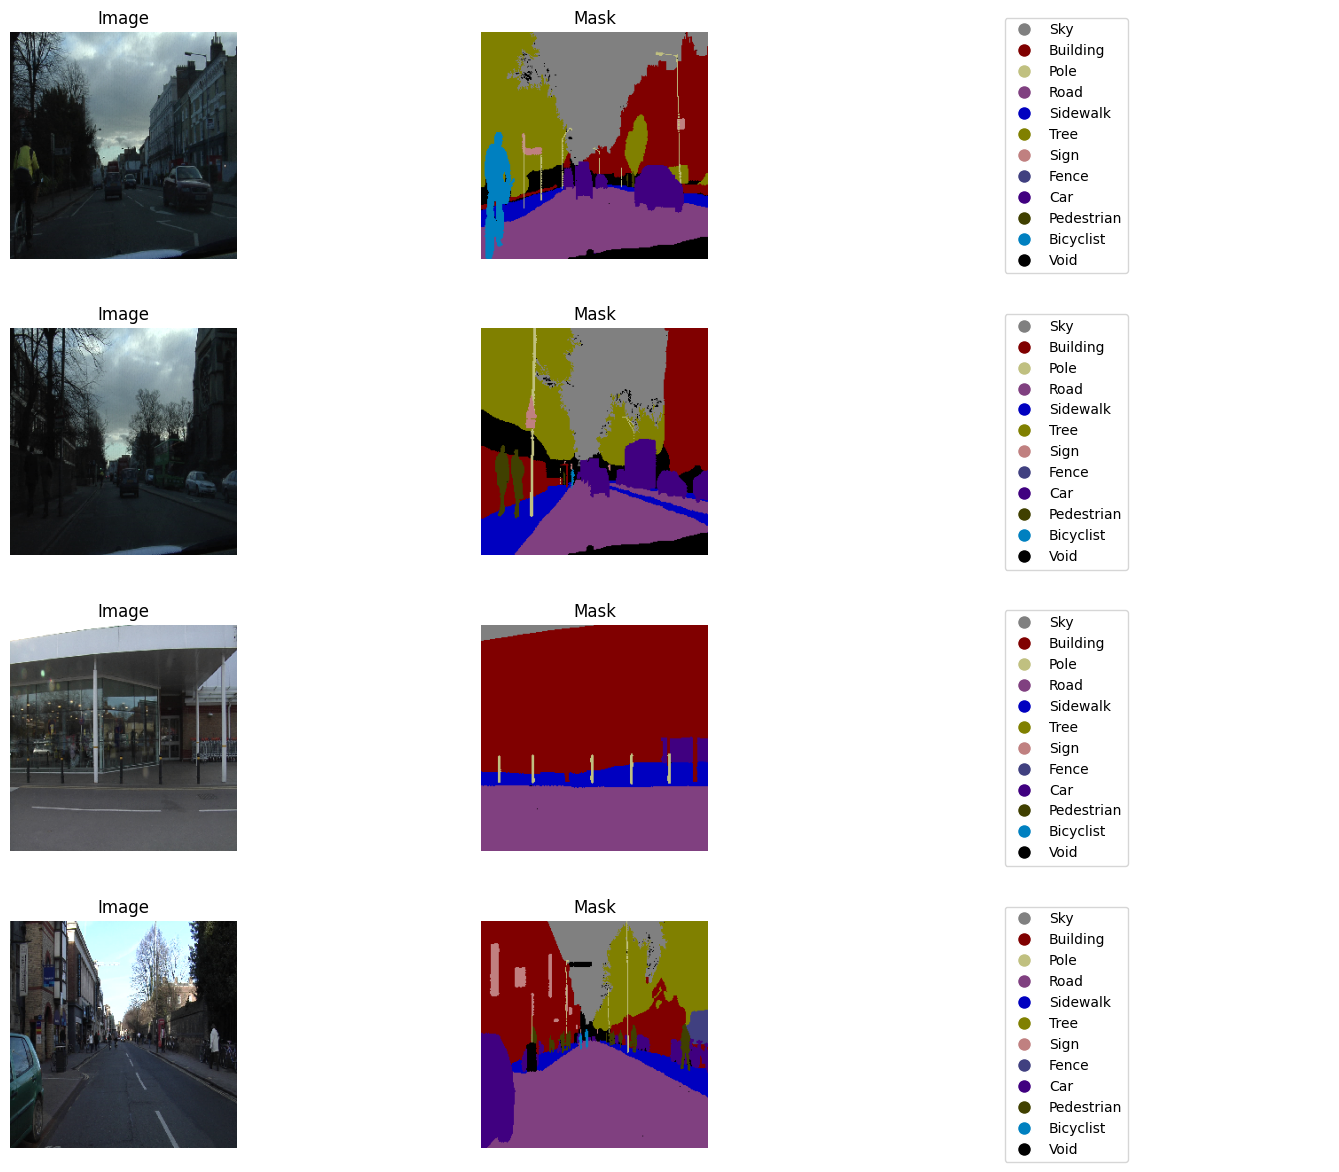

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mappa dei colori per le classi raggruppate
GROUPED_CLASS_COLORS = {
    'Sky': (128, 128, 128),
    'Building': (128, 0, 0),
    'Pole': (192, 192, 128),
    'Road': (128, 64, 128),
    'Sidewalk': (0, 0, 192),
    'Tree': (128, 128, 0),
    'Sign': (192, 128, 128),
    'Fence': (64, 64, 128),
    'Car': (64, 0, 128),
    'Pedestrian': (64, 64, 0),
    'Bicyclist': (0, 128, 192),
    'Void': (0,0,0)
}

# Funzione per convertire le etichette raggruppate in colori
def convert_grouped_labels_to_colors(grouped_labels, group_colors):
    color_labels = np.zeros(grouped_labels.shape + (3,), dtype=np.uint8)
    for group_index, group_name in enumerate(GROUPED_CLASS_COLORS.keys()):
        color = GROUPED_CLASS_COLORS[group_name]
        color_labels[grouped_labels == group_index] = color
    return color_labels

# Funzione per plottare immagini e maschere
def plot_images_and_masks(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))  # 3 colonne per immagini, maschere e legenda
    for i in range(num_samples):
        ax1, ax2, ax3 = axes[i]
        # Visualizza l'immagine
        ax1.imshow(images[i])
        ax1.set_title('Image')
        ax1.axis('off')

        # Converti la maschera in colori
        mask_colors = convert_grouped_labels_to_colors(masks[i], GROUPED_CLASS_COLORS)

        # Visualizza la maschera corrispondente
        ax2.imshow(mask_colors)
        ax2.set_title('Mask')
        ax2.axis('off')

        # Aggiungi una legenda per le classi raggruppate
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color) / 255, markersize=10)
                   for color in GROUPED_CLASS_COLORS.values()]
        labels = list(GROUPED_CLASS_COLORS.keys())
        ax3.legend(handles, labels, loc='center')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Estrai un batch casuale di dati
x, y = next(iter(train_gen))  # Prende il primo batch; per semplicità, non necessariamente casuale

# Seleziona 4 campioni casuali dall'batch
indices = np.random.choice(x.shape[0], 4, replace=False)
selected_images = x[indices]
selected_masks = y[indices]

# Chiama la funzione per plottare
plot_images_and_masks(selected_images, selected_masks, num_samples=4)


##Loading Models

In [ ]:

# Directory che contiene i modelli
models_path = '/content/drive/MyDrive/deep_learning_models_11_classes'

# Funzione per caricare un modello e il suo log
def load_model_and_log(model_name, model_path, log_path):
    # Carica il modello
    print("Loading: ", model_name)
    model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU})
    # Carica il log in un DataFrame
    log_df = pd.read_csv(log_path)
    return model, log_df

# Lista di dizionari per salvare i modelli e i log
models_list = []
logs = []

# Itera attraverso le cartelle nella directory dei modelli
for folder_name in os.listdir(models_path):
    folder_path = os.path.join(models_path, folder_name)

    if os.path.isdir(folder_path):
        model_file = os.path.join(folder_path, f'{folder_name}.keras')
        log_file = os.path.join(folder_path, f'{folder_name}_log.csv')

        if os.path.exists(model_file) and os.path.exists(log_file):
            # Carica il modello e il log
            model, log_df = load_model_and_log(folder_name, model_file, log_file)

            # Salva il modello e il log
            models_list.append({'name': folder_name, 'model': model})
            logs.append({'name': f'{folder_name}_log', 'log': log_df})

            # Creazione di variabili dinamiche
            globals()[folder_name] = model
            globals()[f'{folder_name}_log']= log_df

# Verifica che i modelli e i log siano stati caricati correttamente
for model_info in models_list:
    print(f'Modello caricato: {model_info["name"]}')

for log_info in logs:
    print(f'Log caricato: {log_info["name"]}')


Loading:  fifth_model
Loading:  fourth_model
Loading:  third_model
Loading:  fourth_model_attention
Loading:  fifth_model_attention
Loading:  second_model
Loading:  fourth_model_attention_augmented
Modello caricato: fifth_model
Modello caricato: fourth_model
Modello caricato: third_model
Modello caricato: fourth_model_attention
Modello caricato: fifth_model_attention
Modello caricato: second_model
Modello caricato: fourth_model_attention_augmented
Log caricato: fifth_model_log
Log caricato: fourth_model_log
Log caricato: third_model_log
Log caricato: fourth_model_attention_log
Log caricato: fifth_model_attention_log
Log caricato: second_model_log
Log caricato: fourth_model_attention_augmented_log


## Evaluation

In [ ]:
# Funzione per calcolare la metrica mean IoU su validation
def evaluate_model(model, val_gen):
    results = model.evaluate(val_gen, verbose=0)
    for name, value in zip(model.metrics_names, results):
        if 'custom_mean_io_u' in name:
            return value

# Lista per salvare i risultati
evaluation_results = []

# Valutazione di ogni modello
for model_info in models_list:
    model_name = model_info['name']
    print("Evaluating: ", model_name)
    model = model_info['model']
    mean_iou = evaluate_model(model, val_gen)
    evaluation_results.append({'model_name': model_name, 'mean_iou': mean_iou})

# Creazione del DataFrame per visualizzare i risultati
results_df = pd.DataFrame(evaluation_results)

# Ordinamento dei risultati dal migliore al peggiore
results_df = results_df.sort_values(by='mean_iou', ascending=False)

# Visualizzazione dei risultati
results_df

Evaluating:  fifth_model
Evaluating:  fourth_model
Evaluating:  third_model
Evaluating:  fourth_model_attention
Evaluating:  fifth_model_attention
Evaluating:  second_model
Evaluating:  fourth_model_attention_augmented


,model_name,mean_iou
0,fifth_model,0.626727
1,fourth_model,0.610763
3,fourth_model_attention,0.603283
6,fourth_model_attention_augmented,0.596290
4,fifth_model_attention,0.590613
2,third_model,0.589779
5,second_model,0.575346


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU, Accuracy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Funzione per calcolare le metriche sul validation set
def evaluate_model(model, val_gen, num_classes):
    y_true = []
    y_pred = []

    # Itera attraverso il validation set
    for i in range(len(val_gen)):
        x, y = val_gen[i]
        preds = model.predict(x)
        y_true.append(y)
        y_pred.append(preds)

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred = tf.argmax(y_pred, axis=-1)



    # Calcolo della Mean IoU
    mean_iou_metric = MeanIoU(num_classes=num_classes)
    mean_iou_metric.update_state(y_true, y_pred)
    mean_iou = mean_iou_metric.result().numpy()

    # Ottenere la matrice di confusione totale
    total_cm = mean_iou_metric.total_cm.numpy()
    iou_per_class = np.zeros(num_classes)
    for i in range(num_classes):
        intersection = total_cm[i, i]
        union = total_cm[i, :].sum() + total_cm[:, i].sum() - intersection
        if union > 0:
            iou_per_class[i] = intersection / union
        else:
            iou_per_class[i] = np.nan  # Ignora classi che non appaiono nei dati di validazione

    # Calcolo dell'accuracy
    accuracy_metric = Accuracy()
    accuracy_metric.update_state(y_true, y_pred)
    accuracy = accuracy_metric.result().numpy()

    return mean_iou, iou_per_class, accuracy

# Funzione per stampare le metriche in modo leggibile
def print_metrics(mean_iou, iou_per_class, accuracy, class_names):
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("IoU per classe:")
    for i, class_name in enumerate(class_names):
        iou = iou_per_class[i]
        if not np.isnan(iou):  # Ignora classi con NaN
            print(f"  {class_name}: {iou:.4f}")

# Dati delle metriche per ciascun modello
model_metrics = {}

# Valuta ciascun modello
for model_info in models_list:
    model_name = model_info['name']
    model = model_info['model']
    print(f"\nEvaluating model: {model_name}")

    mean_iou, iou_per_class, accuracy = evaluate_model(model, val_gen, num_classes)

    # Stampa le metriche
    print_metrics(mean_iou, iou_per_class, accuracy, list(CAMVID_CLASSES_GROUPED.keys()))

    # Salva le metriche nel dizionario
    model_metrics[model_name] = {
        'mean_iou': mean_iou,
        'accuracy': accuracy,
        'iou_per_class': iou_per_class
    }





Evaluating model: fifth_model
1/1 [==============================] - 0s 33ms/step
Mean IoU: 0.6522
Accuracy: 0.9135
IoU per classe:
  Sky: 0.9324
  Building: 0.8422
  Pole: 0.2139
  Road: 0.9622
  Sidewalk: 0.8236
  Tree: 0.7957
  Sign: 0.4276
  Fence: 0.5749
  Car: 0.7916
  Pedestrian: 0.4063
  Bicyclist: 0.6259
  Void: 0.4295

Evaluating model: fourth_model
1/1 [==============================] - 0s 28ms/step
Mean IoU: 0.6366
Accuracy: 0.9077
IoU per classe:
  Sky: 0.9254
  Building: 0.8323
  Pole: 0.1652
  Road: 0.9581
  Sidewalk: 0.8107
  Tree: 0.7825
  Sign: 0.3674
  Fence: 0.5845
  Car: 0.7873
  Pedestrian: 0.3648
  Bicyclist: 0.6331
  Void: 0.4277

Evaluating model: third_model
1/1 [==============================] - 0s 28ms/step
Mean IoU: 0.6113
Accuracy: 0.9048
IoU per classe:
  Sky: 0.9271
  Building: 0.8291
  Pole: 0.0855
  Road: 0.9559
  Sidewalk: 0.8045
  Tree: 0.7852
  Sign: 0.3657
  Fence: 0.5406
  Car: 0.7657
  Pedestrian: 0.3264
  Bicyclist: 0.5631
  Void: 0.3871

Evalu

In [22]:
# Funzione per calcolare la mean IoU escludendo la classe 'Void'
def calculate_mean_iou_excluding_void(iou_per_class, class_names, ignore_class='Void'):
    valid_ious = [iou_per_class[i] for i, class_name in enumerate(class_names) if class_name != ignore_class and not np.isnan(iou_per_class[i])]
    mean_iou_excluding_void = np.mean(valid_ious) if valid_ious else 0
    return mean_iou_excluding_void

# Lista delle classi senza 'Void'
class_names_without_void = [class_name for class_name in CAMVID_CLASSES_GROUPED.keys() if class_name != 'Void']

# Aggiornamento della mean IoU nel dizionario delle metriche per ciascun modello
for model_name, metrics in model_metrics.items():
    iou_per_class = metrics['iou_per_class']
    mean_iou_excluding_void = calculate_mean_iou_excluding_void(iou_per_class, CAMVID_CLASSES_GROUPED.keys())
    model_metrics[model_name]['mean_iou'] = mean_iou_excluding_void
    # Rimuovi la metrica iou_Void
    metrics['iou_per_class'] = np.delete(metrics['iou_per_class'], list(CAMVID_CLASSES_GROUPED.keys()).index('Void'))

# Stampa dei nuovi valori di mean IoU
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}, Mean IoU (excluding 'Void'): {metrics['mean_iou']:.4f}")


Model: fifth_model, Mean IoU (excluding 'Void'): 0.6724
Model: fourth_model, Mean IoU (excluding 'Void'): 0.6556
Model: third_model, Mean IoU (excluding 'Void'): 0.6317
Model: fourth_model_attention, Mean IoU (excluding 'Void'): 0.6477
Model: fifth_model_attention, Mean IoU (excluding 'Void'): 0.6336
Model: second_model, Mean IoU (excluding 'Void'): 0.6171
Model: fourth_model_attention_augmented, Mean IoU (excluding 'Void'): 0.6396


In [23]:
model_metrics

{'fifth_model': {'mean_iou': 0.6724106073379517,
  'accuracy': 0.91348046,
  'iou_per_class': array([0.9323982 , 0.84218389, 0.21393234, 0.96224654, 0.82361543,
         0.79574007, 0.42763233, 0.57488185, 0.79162711, 0.40633851,
         0.62592041])},
 'fourth_model': {'mean_iou': 0.6555740860375491,
  'accuracy': 0.9076549,
  'iou_per_class': array([0.92543578, 0.83233202, 0.16515064, 0.95814478, 0.81071413,
         0.78246021, 0.36736205, 0.58450633, 0.78730357, 0.3647936 ,
         0.63311183])},
 'third_model': {'mean_iou': 0.6317226520993493,
  'accuracy': 0.9047753,
  'iou_per_class': array([0.92710906, 0.82914644, 0.08550368, 0.95592761, 0.80453712,
         0.78523386, 0.36565745, 0.54058307, 0.76574981, 0.32640365,
         0.56309742])},
 'fourth_model_attention': {'mean_iou': 0.6476917944171212,
  'accuracy': 0.9093381,
  'iou_per_class': array([0.92954749, 0.83805311, 0.15824425, 0.95807528, 0.80632663,
         0.7947315 , 0.39663261, 0.55523419, 0.77670515, 0.32565126,

In [ ]:
import pandas as pd

# Trasforma il dizionario model_metrics in un DataFrame
data = []
for model_name, metrics in model_metrics.items():
    row = {
        'model': model_name,
        'mean_iou': metrics['mean_iou'],
        'accuracy': metrics['accuracy']
    }
    row.update({f'iou_{class_name}': iou for class_name, iou in zip(CAMVID_CLASSES_GROUPED.keys(), metrics['iou_per_class'])})
    data.append(row)

df_evaluation_results = pd.DataFrame(data)

# Ordina il DataFrame in base a mean_iou in ordine decrescente
df_evaluation_results = df_evaluation_results.sort_values(by='mean_iou', ascending=False)

# Salva il DataFrame in un file Excel
df_evaluation_results.to_excel('/content/drive/MyDrive/semantic-segmentation-camvid/evaluation_results_11_classes.xlsx', index=False)

# Stampa per verifica
df_evaluation_results


,model,mean_iou,accuracy,iou_Sky,iou_Building,iou_Pole,iou_Road,iou_Sidewalk,iou_Tree,iou_Sign,iou_Fence,iou_Car,iou_Pedestrian,iou_Bicyclist
0,fifth_model,0.672412,0.913481,0.932398,0.842184,0.213932,0.962247,0.823615,0.795741,0.427644,0.574882,0.791629,0.406339,0.625920
1,fourth_model,0.655574,0.907655,0.925436,0.832332,0.165151,0.958145,0.810714,0.782460,0.367362,0.584506,0.787304,0.364794,0.633112
3,fourth_model_attention,0.647692,0.909338,0.929547,0.838053,0.158244,0.958075,0.806327,0.794731,0.396633,0.555234,0.776705,0.325651,0.585408
6,fourth_model_attention_augmented,0.639599,0.908242,0.928424,0.835726,0.093433,0.956866,0.806571,0.789337,0.374537,0.594020,0.780662,0.328769,0.547245
4,fifth_model_attention,0.633577,0.903968,0.926473,0.823891,0.123838,0.957749,0.810901,0.774188,0.337300,0.549276,0.771030,0.316479,0.578224
2,third_model,0.631723,0.904775,0.927109,0.829146,0.085504,0.955928,0.804537,0.785234,0.365657,0.540583,0.765750,0.326404,0.563097
5,second_model,0.617087,0.900094,0.923979,0.813169,0.085984,0.957601,0.805698,0.779961,0.362567,0.477638,0.748192,0.295146,0.538020


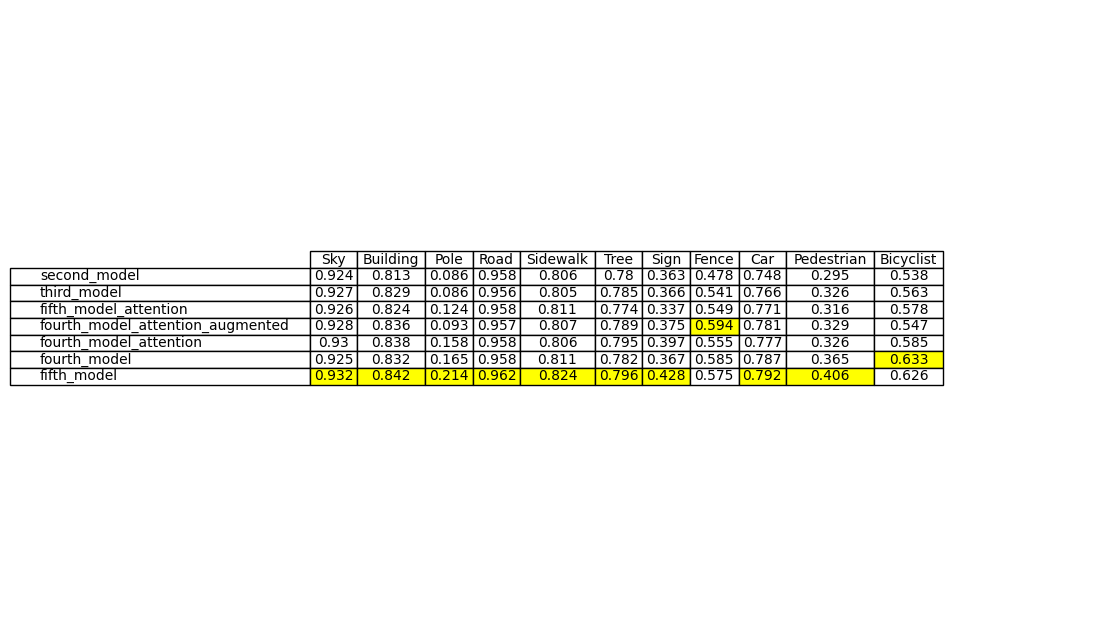

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ordina i modelli in base alla Mean IoU
sorted_model_metrics = sorted(model_metrics.items(), key=lambda x: x[1]['mean_iou'])

class_names_without_void = [class_name for class_name in CAMVID_CLASSES_GROUPED.keys() if class_name != 'Void']

# Creazione di una tabella delle IoU per classe
iou_df = pd.DataFrame(
    {model_name: metrics['iou_per_class'] for model_name, metrics in sorted_model_metrics},
    index=class_names_without_void)

# Arrotonda i valori a due decimali
iou_df = iou_df.round(3)

# Trasponi la tabella per avere i modelli come righe e le classi come colonne
iou_df = iou_df.T

# Funzione per evidenziare il massimo in ogni colonna
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Applica lo stile
styled_iou_df = iou_df.style.apply(highlight_max, subset=pd.IndexSlice[:, :])

# Salva la tabella stilizzata in un file Excel
styled_iou_df.to_excel('/content/drive/MyDrive/semantic-segmentation-camvid/evaluation_results_highlighted.xlsx', engine='openpyxl')

# Visualizza la tabella stilizzata
styled_iou_df

# Se vuoi mostrare la tabella come immagine
fig, ax = plt.subplots(figsize=(12, 8))  # Imposta le dimensioni della figura
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=iou_df.values, colLabels=iou_df.columns, rowLabels=iou_df.index, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(range(len(iou_df.columns))))

# Evidenzia le celle con il valore massimo
for (i, j), val in np.ndenumerate(iou_df.values):
    if val == np.nanmax(iou_df.iloc[:, j].values):
        tbl[(i+1, j)].set_facecolor('yellow')

plt.show()


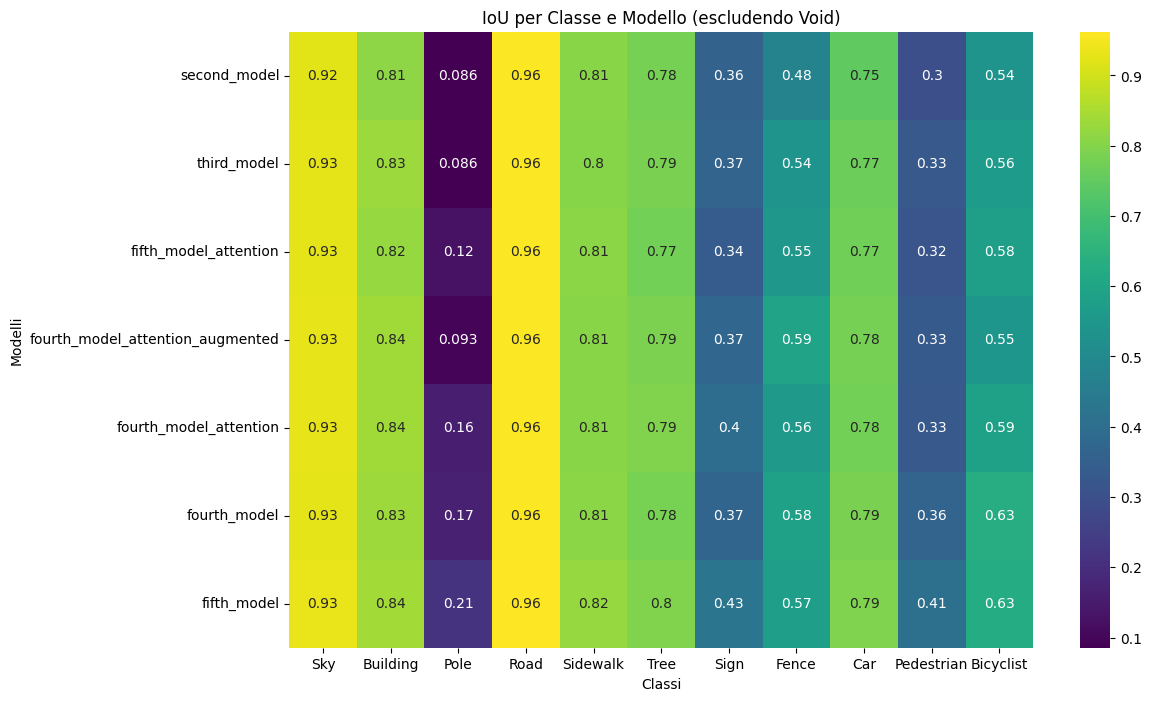

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ordina i modelli in base alla Mean IoU
sorted_model_metrics = sorted(model_metrics.items(), key=lambda x: x[1]['mean_iou'])

# Creazione di una heatmap delle IoU per classe
iou_df = pd.DataFrame(
    {model_name: metrics['iou_per_class'] for model_name, metrics in sorted_model_metrics},
    index=class_names_without_void)


# Rimuove la classe 'Void' dalla heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(iou_df.T, annot=True, cmap='viridis')
plt.xlabel('Classi')
plt.ylabel('Modelli')
plt.title('IoU per Classe e Modello (escludendo Void)')
plt.show()



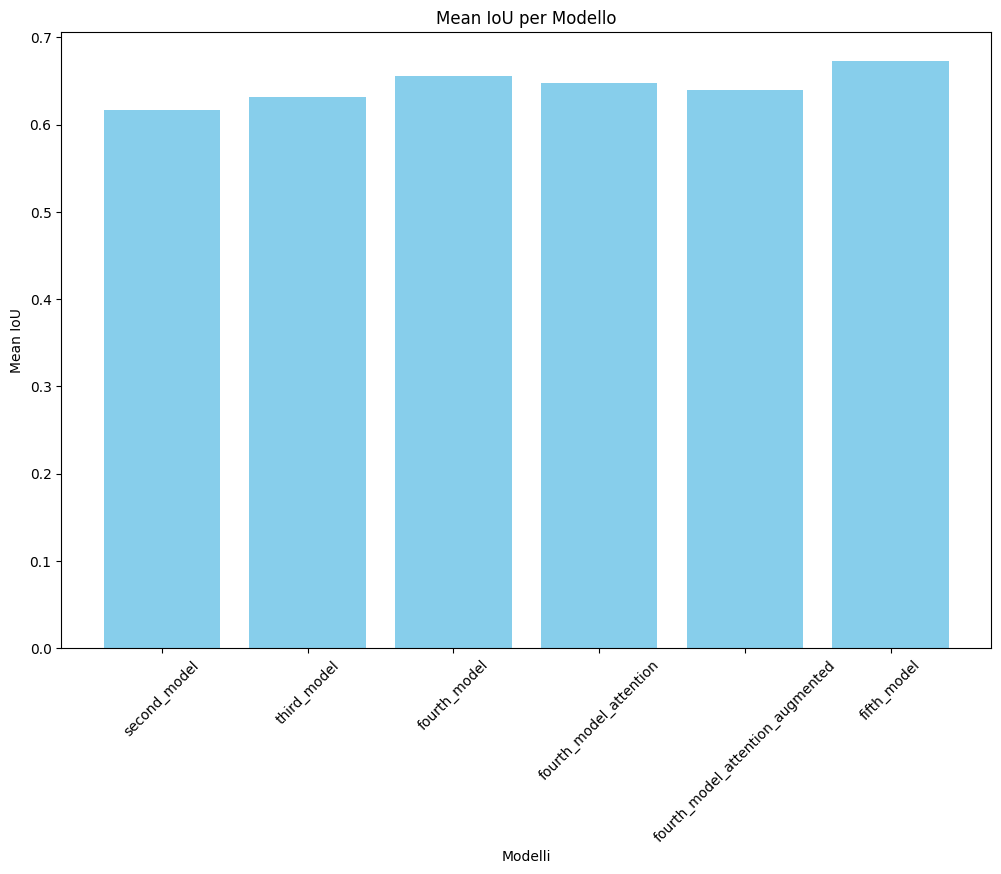

In [ ]:
import matplotlib.pyplot as plt

# Ordine desiderato dei modelli
desired_order = ['second_model', 'third_model', 'fourth_model',
                 'fourth_model_attention','fourth_model_attention_augmented' , "fifth_model"]

# Filtra e ordina i modelli in base all'ordine desiderato
sorted_model_metrics = [(name, model_metrics[name]) for name in desired_order if name in model_metrics]

# Estrai i nomi dei modelli e i Mean IoU
model_names = [model_name for model_name, _ in sorted_model_metrics]
mean_ious = [metrics['mean_iou'] for _, metrics in sorted_model_metrics]

# Crea il barplot
plt.figure(figsize=(12, 8))
plt.bar(model_names, mean_ious, color='skyblue')
plt.xlabel('Modelli')
plt.ylabel('Mean IoU')
plt.title('Mean IoU per Modello')
plt.xticks(rotation=45)
plt.show()


## Prediction on Test



In [ ]:
# Percorsi immagini e maschere
image_test_paths = [os.path.join('data/processed/test/images', fname) for fname in os.listdir('data/processed/test/images')]
mask_test_paths = [os.path.join('data/processed/test/labels', fname) for fname in os.listdir('data/processed/test/labels')]

# Assicurati che i percorsi siano ordinati e corrispondenti
image_test_paths.sort()
mask_test_paths.sort()

test_gen = CamVidDataGenerator(image_test_paths, mask_test_paths, list(CAMVID_CLASSES.values()))


In [ ]:
import pandas as pd

# Valuta il modello migliore sul set di test
best_model_name = 'fifth_model'
best_model = globals()[best_model_name]
mean_iou, iou_per_class, accuracy = evaluate_model(best_model, test_gen, num_classes)

class_names_without_void = [class_name for class_name in CAMVID_CLASSES_GROUPED.keys() if class_name != 'Void']


mean_iou = calculate_mean_iou_excluding_void(iou_per_class, CAMVID_CLASSES_GROUPED.keys())
iou_per_class= np.delete(iou_per_class, list(CAMVID_CLASSES_GROUPED.keys()).index('Void'))

print(f"\nEvaluating best model ({best_model_name}) on test set:")
print_metrics(mean_iou, iou_per_class, accuracy,class_names_without_void)

# Creare un dizionario con le metriche
results = {
    'model': best_model_name,
    'mean_iou': mean_iou,
    'accuracy': accuracy
}
results.update({f'iou_{class_name}': iou for class_name, iou in zip(class_names_without_void, iou_per_class)})

# Creare un DataFrame con una sola riga
df_best_model_results = pd.DataFrame([results])

# Salvare il DataFrame in un file Excel
df_best_model_results.to_excel('/content/drive/MyDrive/semantic-segmentation-camvid/best_model_evaluation_results_11_classes.xlsx', index=False)

# Stampa per verifica
df_best_model_results.head()

1/1 [==============================] - 0s 39ms/step

Evaluating best model (fifth_model) on test set:
Mean IoU: 0.6731
Accuracy: 0.9098
IoU per classe:
  Sky: 0.9340
  Building: 0.8406
  Pole: 0.2221
  Road: 0.9626
  Sidewalk: 0.8226
  Tree: 0.7712
  Sign: 0.4422
  Fence: 0.5344
  Car: 0.7701
  Pedestrian: 0.4256
  Bicyclist: 0.6788


,model,mean_iou,accuracy,iou_Sky,iou_Building,iou_Pole,iou_Road,iou_Sidewalk,iou_Tree,iou_Sign,iou_Fence,iou_Car,iou_Pedestrian,iou_Bicyclist
0,fifth_model,0.673104,0.909825,0.933976,0.84065,0.222106,0.962584,0.822553,0.771234,0.442205,0.534384,0.770071,0.425611,0.678768


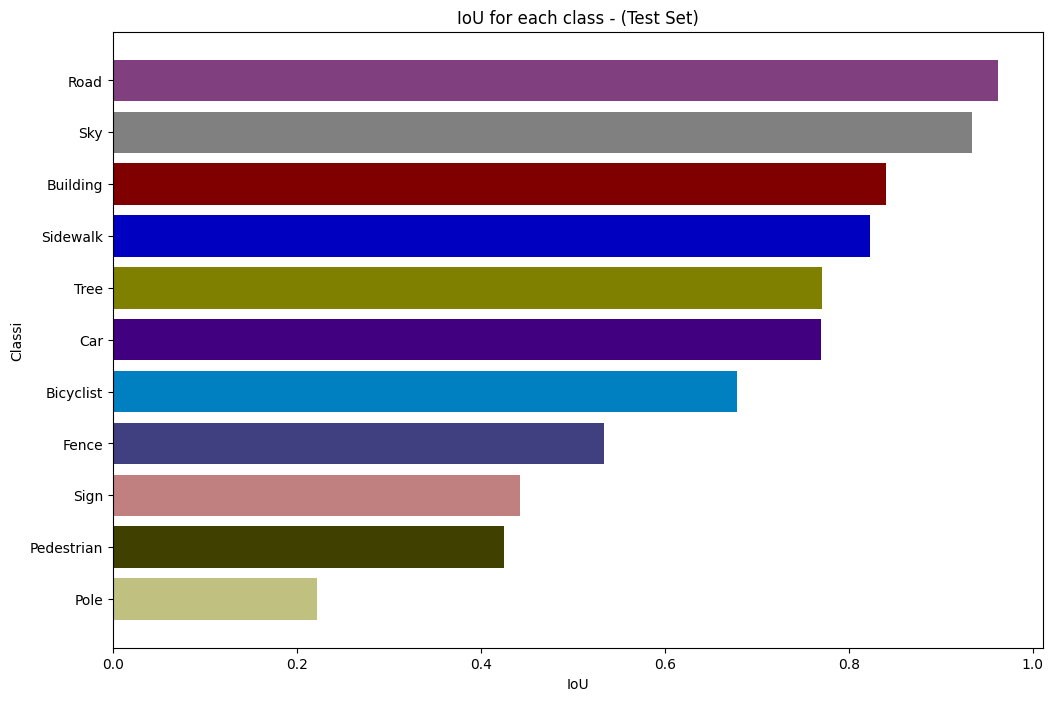

In [ ]:
sorted_indices = np.argsort(iou_per_class)[::-1]
sorted_classes = [list(CAMVID_CLASSES_GROUPED.keys())[i] for i in sorted_indices if not np.isnan(iou_per_class[i])]
sorted_iou = [iou_per_class[i] for i in sorted_indices if not np.isnan(iou_per_class[i])]

sorted_colors = [GROUPED_CLASS_COLORS[cls] for cls in sorted_classes]
sorted_colors = [(r/255, g/255, b/255) for r, g, b in sorted_colors]

# Plot delle metriche ordinate con le classi sull'asse y
plt.figure(figsize=(12, 8))
plt.barh(sorted_classes, sorted_iou, color=sorted_colors)
plt.ylabel('Classi')
plt.xlabel('IoU')
plt.title(f'IoU for each class - (Test Set)')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere la classe con il valore più alto in cima
plt.show()

In [ ]:
# Creazione della mappa dei colori
class_colors = np.array(list(GROUPED_CLASS_COLORS.values()))

# Funzione per plottare immagine, maschera vera e maschera predetta
def plot_predictions(model, data_generator, num_samples=5):
    # Ottenere il numero di batch
    num_batches = len(data_generator)

    # Pescare un batch di immagini dal generatore
    x, y_true = data_generator[np.random.randint(0, num_batches)]

    # Selezionare casualmente num_samples indici
    indices = np.random.choice(x.shape[0], num_samples, replace=False)

    # Effettuare predizioni con il modello
    y_pred = model.predict(x)

    # Funzione per mappare le maschere ai colori
    def colorize_mask(mask):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i in range(len(class_colors)):
            color_mask[mask == i] = class_colors[i]
        return color_mask

    # Creare i plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices):
        # Immagine originale
        axes[i, 0].imshow(x[idx])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Maschera vera
        true_mask_colored = colorize_mask(np.squeeze(y_true[idx]))
        axes[i, 1].imshow(true_mask_colored)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')

        # Maschera predetta
        pred_mask = np.argmax(y_pred[idx], axis=-1)
        pred_mask_colored = colorize_mask(pred_mask)
        axes[i, 2].imshow(pred_mask_colored)
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    patches = [plt.matplotlib.patches.Patch(color=np.array(color)/255, label=name) for name, color in GROUPED_CLASS_COLORS.items()]
    fig.legend(handles=patches, loc = 'center left', bbox_to_anchor=(1.1, 0.5), title = "legend")
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_predictions(best_model, test_gen, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.